# <center>_Toxic Comment Detection_</center>

## _Loading Data_

In [2]:
import pandas as pd
import numpy as np

In [3]:
df = pd.read_csv("labeled.csv", sep=",")
df['toxic'] = df['toxic'].apply(int)

## _EDA_

In [3]:
df.shape

(14412, 2)

In [4]:
df['toxic'].value_counts()

0    9586
1    4826
Name: toxic, dtype: int64

In [5]:
df.query('toxic == 1')['comment']

0                     Верблюдов-то за что? Дебилы, бл...\n
1        Хохлы, это отдушина затюканого россиянина, мол...
2                                Собаке - собачья смерть\n
3        Страницу обнови, дебил. Это тоже не оскорблени...
4        тебя не убедил 6-страничный пдф в том, что Скр...
                               ...                        
14404    ЖЕНЩИНА это ВЕНЕЦ ТВОРЕНИЯ, помните это ваньки...
14405    Сейчас все авиакомпании мира вместе со специал...
14407    Вонючий совковый скот прибежал и ноет. А вот и...
14408    А кого любить? Гоблина тупорылого что-ли? Или ...
14410    КРЫМОТРЕД НАРУШАЕТ ПРАВИЛА РАЗДЕЛА Т.К В НЕМ Н...
Name: comment, Length: 4826, dtype: object

In [6]:
df.query('toxic == 0')['comment']

6        В шапке были ссылки на инфу по текущему фильму...
12       Почитайте посты у этого автора,может найдете ч...
17       Про графику было обидно) я так то проходил все...
28       https: pp.userapi.com c848520 v848520411 11627...
35       Возьмём как пример Россию, западноевропейские ...
                               ...                        
14392    ТАСС, 21 марта. Премьер-министр Новой Зеландии...
14399    65 А чего так мало? Вот у гражданина был рейти...
14406    Потому что запад прошел эту хуйню еще пару сот...
14409    Посмотрел Утомленных солнцем 2. И оказалось, ч...
14411    До сих пор пересматриваю его видео. Орамбо кст...
Name: comment, Length: 9586, dtype: object

In [7]:
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
# nltk.download('punkt')
# nltk.download('stopwords')

stemmer = SnowballStemmer(language='russian')
russian_stop_words = stopwords.words('russian')

def tokenize_sentence(sentence: str, remove_stop_words: bool=True):
    """Преобразует предложения в токены.
    По шагам:
    1) Токенизация - разбиение текста на отдельные слова и знаки пунктуации
    2) Удаляем знаки пунктуации
    3) Удаляем стоп-слова (часто используемые. не несущщие смысловой нагрузки)
    4) Стемминг (stem - корень) - удаление окончаний и приведение к нижнему регистру
    """
    tokens = word_tokenize(sentence, language='russian')
    tokens = [i for i in tokens if i not in string.punctuation]
    if remove_stop_words:
        tokens = [i for i in tokens if i not in russian_stop_words]
    tokens = [stemmer.stem(i) for i in tokens]
    return tokens

In [8]:
example = df.loc[1]['comment']
example

'Хохлы, это отдушина затюканого россиянина, мол, вон, а у хохлов еще хуже. Если бы хохлов не было, кисель их бы придумал.\n'

In [9]:
tokenize_sentence(example)

['хохл',
 'эт',
 'отдушин',
 'затюкан',
 'россиянин',
 'мол',
 'вон',
 'хохл',
 'хуж',
 'есл',
 'хохл',
 'кисел',
 'придума']

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(tokenizer=lambda x: tokenize_sentence(x))

In [33]:
from sklearn.model_selection import train_test_split

features, labels = df['comment'], df['toxic']
features = vectorizer.fit_transform(features)
x_train, x_test, y_train, y_test = train_test_split(features, 
                                                   labels, 
                                                   test_size=0.2, 
                                                   random_state=0)

C:\Python310\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


## _Testing Different Models_

In [38]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

knn = KNeighborsClassifier().fit(x_train, y_train)
tree = DecisionTreeClassifier(random_state=0).fit(x_train, y_train)
log_reg = LogisticRegression(random_state=0).fit(x_train, y_train)

In [39]:
from sklearn.metrics import recall_score, precision_score, roc_auc_score

y_pred_knn = knn.predict(x_test)
y_pred_tree = tree.predict(x_test)
y_pred_log_reg = log_reg.predict(x_test)

knn_precision = precision_score(y_test, y_pred_knn)
tree_precision = precision_score(y_test, y_pred_tree)
log_reg_precision = precision_score(y_test, y_pred_log_reg)

knn_recall = recall_score(y_test, y_pred_knn)
tree_recall = recall_score(y_test, y_pred_tree)
log_reg_recall = recall_score(y_test, y_pred_log_reg)

knn_roc_auc = roc_auc_score(y_test, y_pred_knn)
tree_roc_auc = roc_auc_score(y_test, y_pred_tree)
log_reg_roc_auc = roc_auc_score(y_test, y_pred_log_reg)

print(f'knn_precision: {knn_precision}')
print(f'tree_precision: {tree_precision}')
print(f'log_regr_precision: {log_reg_precision}')
print('----------------------------------')
print(f'knn_recall: {knn_recall}')
print(f'tree_recall: {tree_recall}')
print(f'log_regr_recall: {log_reg_recall}')
print('----------------------------------')
print(f'knn_roc_auc: {knn_roc_auc}')
print(f'tree_roc_auc: {tree_roc_auc}')
print(f'log_regr_roc_auc: {log_reg_roc_auc}')

knn_precision: 0.8192182410423453
tree_precision: 0.7045735475896168
log_regr_precision: 0.9160063391442155
----------------------------------
knn_recall: 0.5212435233160622
tree_recall: 0.5906735751295337
log_regr_recall: 0.5989637305699482
----------------------------------
knn_roc_auc: 0.7316853695829529
tree_roc_auc: 0.7330323037274362
log_regr_roc_auc: 0.7856653897896665


## _kNN_

In [40]:
from sklearn.model_selection import GridSearchCV

knn_grid = GridSearchCV(KNeighborsClassifier(), 
                        param_grid={'n_neighbors': range(10, 61, 10)}, 
                        scoring='precision',
                        cv=3)
knn_grid.fit(x_train, y_train)

GridSearchCV(cv=3, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(10, 61, 10)},
             scoring='precision')

In [41]:
print(f'best params: {knn_grid.best_params_}')
print(f'best score: {knn_grid.best_score_}')

knn.set_params(**knn_grid.best_params_).fit(x_train, y_train)    #эквивалентно knn_grid.fit(x_train y_train)

y_pred_knn_best = knn.predict(x_test)                            #эквивалентно knn_grid.predict(x_test)
knn_precision_best = precision_score(y_test, y_pred_knn_best)
knn_recall_best = recall_score(y_test, y_pred_knn_best)
knn_roc_auc_best = roc_auc_score(y_test, y_pred_knn_best)
print(f'kNN precision with best params: {knn_precision_best}')
print(f'kNN recall with best params: {knn_recall_best}')
print(f'kNN roc_auc with best params: {knn_roc_auc_best}')
# print('-------------------------------------------------')
# print(classification_report(y_test, y_pred_knn_best))

best params: {'n_neighbors': 60}
best score: 0.9308787636810716
kNN precision with best params: 0.9334763948497854
kNN recall with best params: 0.45077720207253885
kNN roc_auc with best params: 0.717307266312599


## _Logistic Regression_

In [54]:
from sklearn.linear_model import LogisticRegressionCV

cs = np.logspace(-1, 0, 50)
log_reg_cv = LogisticRegressionCV(Cs=cs, 
                                  cv=3, 
                                  verbose=0, 
                                  max_iter=200,
                                  scoring='precision',
                                  random_state=0)
log_reg_cv.fit(x_train, y_train)

LogisticRegressionCV(Cs=array([0.1       , 0.10481131, 0.10985411, 0.11513954, 0.12067926,
       0.12648552, 0.13257114, 0.13894955, 0.14563485, 0.1526418 ,
       0.15998587, 0.16768329, 0.17575106, 0.184207  , 0.19306977,
       0.20235896, 0.21209509, 0.22229965, 0.23299518, 0.24420531,
       0.25595479, 0.26826958, 0.28117687, 0.29470517, 0.30888436,
       0.32374575, 0.33932218, 0.35564803, 0.37275937, 0.39069399,
       0.40949151, 0.42919343, 0.44984327, 0.47148664, 0.49417134,
       0.51794747, 0.54286754, 0.5689866 , 0.59636233, 0.62505519,
       0.65512856, 0.68664885, 0.71968567, 0.75431201, 0.79060432,
       0.82864277, 0.86851137, 0.91029818, 0.95409548, 1.        ]),
                     cv=3, max_iter=200, random_state=0, scoring='precision')

In [55]:
print(f'best C: {log_reg_cv.C_}')

y_pred_lr_best = log_reg_cv.predict(x_test)

lr_precision_best = precision_score(y_test, y_pred_lr_best)
lr_recall_best = recall_score(y_test, y_pred_lr_best)
lr_roc_auc_best = roc_auc_score(y_test, y_pred_lr_best)
print(f'LR precision with best params: {lr_precision_best}')
print(f'LR recall with best params: {lr_recall_best}')
print(f'LR roc_auc with best params: {lr_roc_auc_best}')
# print('-------------------------------------------------')
# print(classification_report(y_test, y_pred_lr_best))

best C: [0.10481131]
LR precision with best params: 0.9915254237288136
LR recall with best params: 0.12124352331606218
LR roc_auc with best params: 0.5603610734411385


In [77]:
from sklearn.metrics import precision_recall_curve

pr, rc, th = precision_recall_curve(y_true=y_test, 
                                    probas_pred=log_reg_cv.predict_proba(x_test)[:,1])

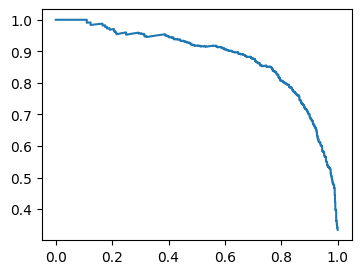

In [78]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.figure(figsize=(4, 3))
plt.plot(rc, pr)

In [79]:
np.where(pr > 0.95)

(array([2464, 2471, 2472, 2473, 2474, 2475, 2476, 2477, 2478, 2479, 2480,
        2481, 2482, 2483, 2484, 2485, 2486, 2487, 2488, 2489, 2490, 2491,
        2492, 2493, 2494, 2495, 2496, 2497, 2498, 2499, 2500, 2501, 2502,
        2503, 2504, 2545, 2546, 2547, 2548, 2549, 2550, 2551, 2552, 2553,
        2554, 2555, 2556, 2557, 2558, 2559, 2560, 2561, 2562, 2563, 2564,
        2565, 2566, 2567, 2568, 2569, 2570, 2571, 2572, 2573, 2574, 2575,
        2576, 2577, 2578, 2579, 2580, 2581, 2582, 2583, 2584, 2585, 2586,
        2587, 2588, 2589, 2590, 2591, 2592, 2593, 2594, 2595, 2596, 2597,
        2598, 2599, 2600, 2601, 2602, 2603, 2604, 2605, 2606, 2607, 2608,
        2609, 2610, 2611, 2612, 2613, 2614, 2615, 2616, 2617, 2618, 2619,
        2620, 2621, 2622, 2623, 2624, 2625, 2626, 2627, 2628, 2629, 2630,
        2631, 2632, 2633, 2634, 2635, 2636, 2637, 2638, 2639, 2640, 2641,
        2642, 2643, 2644, 2645, 2646, 2647, 2648, 2649, 2650, 2651, 2652,
        2653, 2654, 2655, 2656, 2657, 

In [86]:
print(th[2464], th[2862])

0.4188884602325338 0.7890727270129213


## _Decision Tree_

## _Gradient Descent_

## _Random Forest_